# Explore particulate matter data using IBM Cloud SQL Query <br>



<div class="pull-left"><left><img style="float: right;" src="http://developer.ibm.com/clouddataservices/wp-content/uploads/sites/85/2018/01/ibm-cloud-object-storage-logo-small.png" width="100" margin=50></left></div>
<div style="text-align:center">
<b>IBM Cloud SQL Query</b> is IBM's <b>serverless SQL</b> service on data in <b>Cloud Object Storage</b>. It allows you to run ANSI SQL on Parquet, CSV and  JSON data sets. It is based on Apache Spark SQL as the query engine in the background. This means you do <b>not</b> have to provision and manage your own Apache Spark instance and think about resources you need to request, but a simple Python client (like the IBM Watson Studio Notebook) is sufficient. <br><br></div>
This notebook is an introduction to using the SQL Query API to run SQL statements in a programmatic way. It uses the <a href="https://github.com/IBM-Cloud/sql-query-clients/tree/master/Python" target="_blank" rel="noopener noreferrer">ibmcloudsql</a> Python library for this purpose. The notebook also demonstrates how you can combine SQL Query with visualization libraries such as <b>PixieDust, folium</b> or <b>matplotlib</b> to explore particulate matter data. 

The notebook works with Python 3.5. and the visualization has been verified to work the Firefox.  

## Table of contents
1. [Set up the libraries](#setup)<br>
2. [Configure SQL Query](#configure)<br>
3. [About the particulate matter data ](#data)<br>
4. [Explore the particulate matter data](#sql)<br>
    4.1 [Understand data and schema](#sqlsimple)<br>
    4.2 [Use geo spatial library to find sensors near by](#sqlspatial)<br>
    4.3 [Explore humidity to validate particulate matter measurements](#sqlexplore)<br>
    4.4 [Cleanse Data to filter out valid measurements ](#sqlcleansing)<br>
5. [Next steps](#nextsteps)<br>


## <a id="setup"></a> 1. Set up the libraries
 
This notebook needs several Python libraries. If the library is not pre-installed you have to install it first. Pre-installed libraries only need to be imported.


**ibmcloudsql** - is an IBM-provided Python library which provides a Python wrapper around the SQL Query REST API.

**getpass** - is an open source Python library which provides a way to prompt the user for a value, usually a password, without echoing what they type to the console. 

**pandas** - is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.


In [ ]:
!conda install pyarrow
!pip -q install ibmcloudsql

In [2]:
import ibmcloudsql
import getpass
import pandas as pd
import urllib.parse
from IPython.display import display as dp  

 ## <a id="configure"></a> 2. Configure SQL Query

1. Get an **API key** for your IBM Cloud account. Log on to the IBM Cloud console and go to <a href="https://console.bluemix.net/iam/#/apikeys" target="_blank">Manage > Security > Platform API Keys</a> give the key a custom name and click the **Create** button. In the next dialog click **Show** and copy the key to your clipboard and paste it below in this notebook.
2. Get the **instance CRN** for your SQL Query instance. Go to  <a href="https://console.bluemix.net/dashboard/apps" target="_blank">IBM Cloud console dashboard</a>. Make sure you have **All Resources** selected as resource group. In the section **Services** you can see your instance of SQL Query. Select the SQL Query that you want to use. In the SQL Query dashboard page that opens up there is a section called **REST API** with a button labelled **Instance CRN**. Click the button to copy the CRN into your clipboard and paste it into the cell below.
3. You need to specify the location on Cloud Object Storage where your `query results` should be written. Go to the UI for your IBM Cloud Object Storage instance and list the buckets. From the pull down menu of the bucket you want to use to store your query results, select "Bucket SQL URL"  and copy the  **URL** (format `cos://<endpoint>/<bucket>/[<prefix>]`).  
<br/>

In [ ]:

#enter your IBM Cloud platform apikey 
apikey=getpass.getpass('Enter IBM Cloud API Key (leave empty to use previous one): ') or apikey

#Enter your instance crn
instancecrn_encoded=input('Enter SQL Query Instance CRN (leave empty to use previous one): ') or instancecrn_encoded

#Decode the crn 
instancecrn=urllib.parse.unquote(instancecrn_encoded)
print(instancecrn)

#Enter your target url 
targeturl=input('Enter target URL for SQL results (leave empty to use ): ') or targeturl
 

### 2.1 Configure ibmcloudsql.SQLQuery and log on to IBM Cloud

ibmcloudsql.SQLQuery is the class which wraps the REST API. You configure it with the parameters required to log on to the IBM Cloud and talk to the SQL Query service instance created upfront. You then log on to the IBM Cloud. 

In [5]:
sqlClient = ibmcloudsql.SQLQuery(apikey, instancecrn, targeturl, client_info='SQL Query Particulate Matter Data Exploration and Cleansing Notebook')
sqlClient.logon()

### 2.2 Get the link to the SQL Query Instance UI

You have logged on to IBM Cloud now and the output from the cell below provides you the link to your SQL Query Instance UI.

In the joblist you will find not only the queries you submitted using the UI but also the jobs you will submit using the REST API in the next steps. 

For each query you submitted you can investigate the result as well as the query details which may help when you want to debug your SQL. 

In [6]:
print('\nYour SQL Query web console link:\n')
sqlClient.sql_ui_link() 


Your SQL Query web console link:

https://sql.ng.bluemix.net/sqlquery/?instance_crn=crn:v1:bluemix:public:sql-query:us-south:a/e2cb778ce7da6d8945e99e5f02b48a43:6dfbbb81-bbfb-4609-8c9a-1ec9c40e8067::


## <a id="data"></a> 3. About the particulate matter data from the Open Knowledge Lab Stuttgart 
 
In 2015 the <a href="https://codefor.de/stuttgart/" target="_blank">Open Knowledge Lab Stuttgart</a> (OK Lab) started an effort to collect particulate matter data with low budget sensors. The OK Lab provides installation instructions for sensor cards which use the sensor types dht22 (measuring temperature and humidity) and sds011 (measuring particles less than 10 µm (P1)and less than 2.5 µm (P2) in μg/m³). In most cases these two sensor types are installed in the same location. More than 4000 sensor cards have now been installed all over Germany. The data from the sensors are collected and the OK Lab Stuttgart makes them publicly available. 

IBM has made the these data available on IBM Cloud Object Storage as .csv and .parquet files accessible via SQL Query using these naming conventions: 

    oklabdata/csv/<sensor_type>/<yyyy>/<sensor_type>-<yyyy>-<mm>.csv 
    oklabdata/parquet/<sensor_type>/<yyyy>/<mm>/part-....snappy.parquet  
    
In the following you will focus on data collected by these two sensor types in 2017/07. 

## <a id="sql"></a> 4. Explore particulate matter data 

In this section, you will:

- [4.1 Understand the data schema](sqlsimple)
- [4.2 Use the geospatial library to find sensors](sqlspatial)
- [4.3 Explore humidity to validate particulate matter measurements](sqlexplore)
- [4.4 Cleanse the data to filter out valid measurements](sqlcleansing)

### <a id="sqlsimple"></a> 4.1 Understand the data schema 

**Number of installed dht22 sensors in 2017/07** 

In [7]:

sql="""
SELECT COUNT(sid_dht22) as count_sids_dht22 
FROM (SELECT DISTINCT sensor_id as sid_dht22 
FROM cos://us-geo/sql/oklabdata/parquet/dht22/2017/07/  STORED AS PARQUET)
"""

result_df = sqlClient.run_sql(sql)
if isinstance(result_df, str):
    print(result_df)
else:
    dp(result_df.head(2))

,count_sids_dht22
0,1489


**Number of installed sds011 sensors in 2017/07** 

In [8]:
sql="""
SELECT COUNT(sid_sds011) as count_sids_sds011 
FROM (SELECT DISTINCT sensor_id as sid_sds011 FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET)""" 
result_df = sqlClient.run_sql(sql)

if isinstance(result_df, str):
    print(result_df)
else:
    dp(result_df.head(2))

,count_sids_sds011
0,1813


**DHT22 schema**

In [9]:
sql='SELECT * FROM cos://us-geo/sql/oklabdata/parquet/dht22/2017/07/ STORED AS PARQUET LIMIT 5' 
result_df = sqlClient.run_sql(sql)
if isinstance(result_df, str):
    print(result_df)
else:
    dp(result_df.head(5))

,sensor_id,sensor_type,location,lat,lon,timestamp,temperature,humidity
0,1193,DHT22,585,51.193,7.076,2017-07-27T00:00:03.000Z,18.3,99.9
1,1193,DHT22,585,51.193,7.076,2017-07-27T00:00:07.000Z,18.3,99.9
2,1193,DHT22,585,51.193,7.076,2017-07-27T00:00:11.000Z,18.3,99.9
3,1193,DHT22,585,51.193,7.076,2017-07-27T00:00:16.000Z,18.3,99.9
4,1193,DHT22,585,51.193,7.076,2017-07-27T00:00:20.000Z,18.3,99.9


In [10]:
result_df.dtypes

sensor_id        int64
sensor_type     object
location         int64
lat            float64
lon            float64
timestamp       object
temperature    float64
humidity       float64
dtype: object

**SDS011 schema**

In [11]:
sql='SELECT * FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET LIMIT 5' 
result_df = sqlClient.run_sql(sql)

if isinstance(result_df, str):
    print(result_df)
else:
    dp(result_df.head(5))

,sensor_id,sensor_type,location,lat,lon,timestamp,P1,durP1,ratioP1,P2,durP2,ratioP2
0,1192,SDS011,585,51.193,7.076,2017-07-27T00:00:03.000Z,11.53,NaN,NaN,10.33,NaN,NaN
1,1192,SDS011,585,51.193,7.076,2017-07-27T00:00:07.000Z,11.73,NaN,NaN,10.43,NaN,NaN
2,1192,SDS011,585,51.193,7.076,2017-07-27T00:00:11.000Z,12.05,NaN,NaN,10.70,NaN,NaN
3,1192,SDS011,585,51.193,7.076,2017-07-27T00:00:15.000Z,12.20,NaN,NaN,10.80,NaN,NaN
4,1192,SDS011,585,51.193,7.076,2017-07-27T00:00:20.000Z,12.10,NaN,NaN,10.80,NaN,NaN


In [12]:
result_df.dtypes

sensor_id        int64
sensor_type     object
location         int64
lat            float64
lon            float64
timestamp       object
P1             float64
durP1          float64
ratioP1        float64
P2             float64
durP2          float64
ratioP2        float64
dtype: object

### <a id="sqlspatial"></a> 4.2  Use the geospatial library to find sensors 

SQL Query supports a **geospatial library**. You use this library to find the sensors close to a given location. 

- <a href="https://console.stage1.bluemix.net/docs/services/sql-query/sql-query.html#overview" target="_blank" rel="noopener noreferrer">SQL query overview</a> provides information about which geospatial functions you can use with SQLQuery  
- <a href="https://console.stage1.bluemix.net/docs/services/sql-query/geospatial.html#geospatial-analytic"  target="_blank" rel="noopener noreferrer">Geospatial analytics</a> provides samples that use geospatial functions

We used the geo coordinates of Stuttgart. But you can of course get the geo coordinates for your home location and figure out if there are sensors in your area.


Longitude of Stuttgart: 9.1829321

Latitude of Stuttgart: 48.7758459


#### Find sds011 sensors close to this geolocation

In [13]:
sql="""
WITH prefiltered AS 
     (SELECT s.sensor_id sensor_id, s.lon lon, s.lat lat, MAX(s.lon) max_lon, MAX(s.lat) max_lat , s.location location
      FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET s
      WHERE isnotnull(s.lon) AND isnotnull(s.lon)GROUP BY s.sensor_id, s.lon, s.lat, s.location
     )
SELECT sensor_id, ST_Distance(ST_Point(max_lon, max_lat), ST_Point(9.1829321, 48.7758459)) AS distance , location as location, max_lon as lon, max_lat as lat 
FROM prefiltered 
WHERE ST_Distance(ST_Point(max_lon, max_lat), ST_Point(9.1829321, 48.7758459)) <= 1000.0 
ORDER BY distance asc"""


sds011_sensors = sqlClient.run_sql(sql)

if isinstance( sds011_sensors, str):
    print(sds011_sensors)
else:
    dp( sds011_sensors.head(5))

,sensor_id,distance,location,lon,lat
0,809,454.208121,387,9.185,48.772
1,649,582.152972,309,9.175,48.776
2,795,655.159898,381,9.188,48.771
3,164,727.843825,72,9.174,48.773
4,962,782.876813,469,9.177,48.770


#### Show location information for the sds011 sensors 

**Note:** You use the visualization library **folium** to this, but first you must install it and import it.

In [14]:
# install and import folium library 

!pip -q install folium
import folium 
 
# Create a map of the Stuttgart area including location latitude = 48.7758459, longitude = 9.1829321
m = folium.Map(location=[48.7758459, 9.1829321], zoom_start=15)

# Add a circle marker to the map at location latitude = 48.7758459, longitude = 9.1829321

marker=folium.CircleMarker(location=[48.7758459, 9.1829321])
marker.add_to(m) 

# Add markers to the map where sensors of type sds011 within a 1000 meter distance to location [48.7758459, 9.182932] 1are installed

for i in range(0,len(sds011_sensors)):
    marker=folium.Marker([sds011_sensors.iloc[i]['lat'],  sds011_sensors.iloc[i]['lon']], popup=str( sds011_sensors.iloc[i]['sensor_id']),icon=folium.Icon(color='blue'))
    marker.add_to(m)


m 

#### Find dht22 sensors close to this geolocation

In [15]:
sql="""
WITH prefiltered AS 
     (SELECT d.sensor_id sensor_id, d.lon lon, d.lat lat, MAX(d.lon) max_lon, MAX(d.lat) max_lat , d.location location
      FROM cos://us-geo/sql/oklabdata/parquet/dht22/2017/07/ STORED AS PARQUET d
      WHERE isnotnull(d.lon) AND isnotnull(d.lon)GROUP BY d.sensor_id, d.lon, d.lat, d.location
     )
SELECT sensor_id, ST_Distance(ST_Point(max_lon, max_lat), ST_Point(9.1829321, 48.7758459)) AS distance , location as location, max_lon as lon, max_lat as lat 
FROM prefiltered 
WHERE ST_Distance(ST_Point(max_lon, max_lat), ST_Point(9.1829321, 48.7758459)) <= 1000.0 
ORDER BY distance asc"""


dht22_sensors = sqlClient.run_sql(sql)

if isinstance(dht22_sensors , str):
    print(dht22_sensors)
else:
    dp(dht22_sensors.head(5))

,sensor_id,distance,location,lon,lat
0,810,454.208121,387,9.185,48.772
1,650,582.152972,309,9.175,48.776
2,796,655.159898,381,9.188,48.771
3,165,727.843825,72,9.174,48.773
4,963,782.876813,469,9.177,48.770


#### Show location information for the dht22 sensors

In [16]:
# Add markers to the map where sensors of type dht22 within a 1000 meter distance to location [48.7758459, 9.182932] are installed

for i in range(0,len(dht22_sensors)):
    marker=folium.Marker([dht22_sensors.iloc[i]['lat'], dht22_sensors.iloc[i]['lon']], popup=str(dht22_sensors.iloc[i]['sensor_id']), icon=folium.Icon(color='red'))
    marker.add_to(m)

m 

Let's work with the sensors <b>sensor_id 809</b> (sds011) and <b>sensor_id 810 </b> (dht22) which are closest to the geolocation and installed in the same <b>location 387</b>.
For data visualization, you will use the matplotlib and Pixiedust libraries. 

### <a id="sqlexplore"></a> 4.3 Explore humidity to validate particulate matter measurements

The sds011 sensor data sheet states that it operates correctly when the humidity is less than 70%. When the humidity is higher it will condense as water at the particles and the particles will appear larger than they in fact are.

So let's have a look at the hourly minimal, maximal, and average humidity values for different days in July. 

In [17]:
sql="""
SELECT min(d.humidity) as min_hum , max(d.humidity) max_hum, avg(d.humidity) avg_hum, hour(d.timestamp) AS hour, datediff('2017-07-31', d.timestamp) day  
FROM cos://us-geo/sql/oklabdata/parquet/dht22/2017/07/ STORED AS PARQUET d 
WHERE  d.sensor_id=810 
GROUP BY day, hour
ORDER BY day, hour asc"""

dht22_201707_810_df = sqlClient.run_sql(sql)

#### Visualize the humidity changes during the course of the day in July 2017

The matplotlib visualization library requires a matrix as input format. So in the next steps you will convert the dataframe into a matrix, which you can then use to visualize the humidity value changes during the day in July 2017. 

In [18]:
dht22_201707_810_df2=dht22_201707_810_df.set_index(['day','hour'], drop = True)
del dht22_201707_810_df2["max_hum"]
del dht22_201707_810_df2["min_hum"]


In [19]:
import numpy as np
humMatrix =  np.zeros(shape=(31,24))

for i in range(31):
    for j in range(24): 
            humMatrix[i,j] = dht22_201707_810_df2.loc[(i,j),:]
         
        

Refer to the <a href="ttps://matplotlib.org/examples/color/colormaps_reference.html" target="_blank" rel="noopener noreferrer">matplotlib colormaps reference</a> to see which color maps can be used with cmap in `imshow()`.

In [20]:
import matplotlib.pyplot as plt 
plt.imshow(humMatrix,cmap='YlGnBu', aspect='auto')
plt.title('Humidity  Stuttgart July 2018')
plt.colorbar()

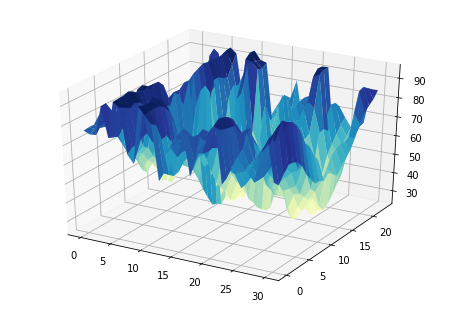

In [21]:
from mpl_toolkits.mplot3d import Axes3D

x,y = np.mgrid[0:31,0:24]

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x,y,humMatrix, rstride=1,cstride=1,cmap='YlGnBu')

It turns out that the humidity during the night is very high. So you can expect valid particulate matter measurements only during the day. Also there are some rainy days that may have to be excluded from the particulate matter measurements to ensure that you analyse only valid data. 

To confirm the observation for the average humidity let's have a look a specific day(s) in July but not only at the average humidity but also at the minimal and maximal humidity. 

Use the visualization library PixieDust to do this. 

<b>PixieDust</b> is an open source helper library that works as an add-on to Jupyter notebooks, mainly used for visualization here. 

In [22]:
from pixiedust.display import * 

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table USER_PREFERENCES created successfully
Table service_connections created successfully



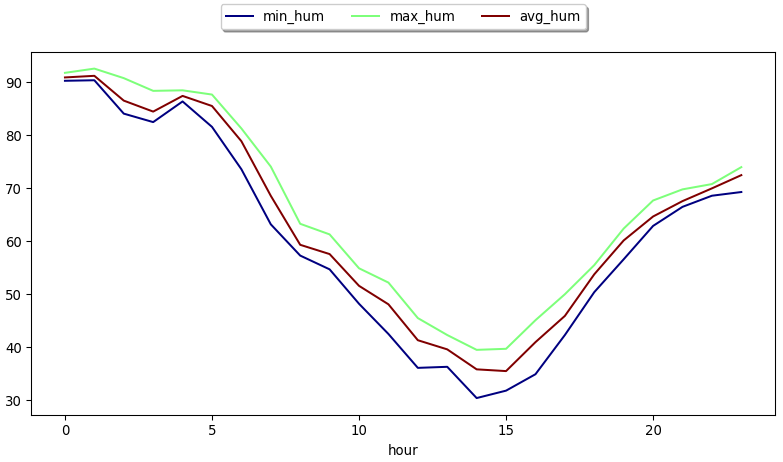

In [ ]:
sql="""
SELECT min(d.humidity) as min_hum , max(d.humidity) max_hum, avg(d.humidity) avg_hum, hour(d.timestamp) AS hour 
FROM cos://us-geo/sql/oklabdata/parquet/dht22/2017/07/ STORED AS PARQUET d 
WHERE date(d.timestamp)=to_date("2017-07-28") and d.sensor_id=810 
GROUP BY hour"""

dht22_201707_810_df = sqlClient.run_sql(sql)

if isinstance(dht22_201707_810_df, str):
    print(dht22_201707_810_df)
else:
    display(dht22_201707_810_df)

### <a id="sqlcleansing"></a> 4.4  Cleanse the data to filter out valid measurements  

The previous queries have shown that you have to filter out the valid P1, P2 measurements. Only the when the humidity is less than 70% can you rely on the particulate matter measurements. So let's cleanse the data and have another look at the particulate matter measurements in July. 
 
To do this, first filter out all timestamps for the dht22 sensor in location 387 where humidity <= 70 % was measured. Then find the particulate matter measurements that match in terms of time (10 second interval) for the sds011 sensor in the same location (temporal join). 

In [24]:
sql="""
WITH  hlt70 AS 
    (SELECT timestamp as ts_hlt70 FROM cos://us-geo/sql/oklabdata/parquet/dht22/2017/07/ STORED AS PARQUET 
     WHERE location=387  and humidity <= 70
     ) 
SELECT avg(sds011.p1) as avg_p1,  max(sds011.p1) as max_p1,
       avg(sds011.p2) as avg_p2,  max(sds011.p2) as  max_p2, 
       hour(sds011.timestamp) as hour , datediff('2017-07-31', sds011.timestamp) as  day 
FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/  STORED AS PARQUET sds011 , hlt70  
WHERE  sds011.location=387 and 
       (to_unix_timestamp(sds011.timestamp) - 10 < to_unix_timestamp(hlt70.ts_hlt70)) and 
       (to_unix_timestamp(hlt70.ts_hlt70) < to_unix_timestamp(sds011.timestamp) + 10) 
GROUP BY day, hour 
ORDER BY day, hour asc""" 

sds011_201707_809 = sqlClient.run_sql(sql)


In [25]:
sds011_201707_809_df=sds011_201707_809.set_index(['day','hour'], drop = True)


In [26]:
del sds011_201707_809_df["max_p1"] 
del sds011_201707_809_df["max_p2"] 
del sds011_201707_809_df["avg_p2"] 

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


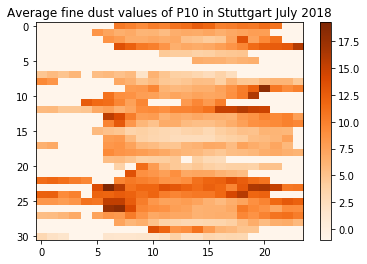

In [27]:
finedustMatrix =  np.zeros(shape=(31,24))

for i in range(31):
    for j in range(24):
        if (i,j) in sds011_201707_809_df.index:  
            finedustMatrix[i,j] = sds011_201707_809_df.loc[(i,j),:]
        else: 
            finedustMatrix[i,j] = -1

plt.imshow(finedustMatrix,cmap='Oranges', aspect='auto')
plt.title('Average fine dust values of P10 in Stuttgart July 2018')
plt.colorbar()

## 7. Next steps<a id="nextsteps"></a>

Of course there are other ways to deal with the humidity issue. For example:

- You can try to correct the particulate measurement data to make the measurements during periods of high humidity usable for the further evaluation.
- You may want to look for outliers indicating that the sensor is not working correctly anymore. 
- Last but not least one may to want to compare the data with official measurements close by to gain trust in the data.

After you have completed the data preparation step you can dive deeper into data analysis using, for example, Watson Studio with Watson Machine Learning.


### Citation
OK Lab Stuttgart particulate matter data - <a href="https://creativecommons.org/licenses/by/3.0/de/" target="_blank" rel="noopener noreferrer">Creative Commons DE 3.0 Lizenz (CC BY 3.0 DE)</a>.

### Author
**Dr. Ute Schuerfeld** is a software developer for IBM Cloud SQL Query at IBM, Germany. 

Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>